In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

from fastai.vision import *
from fastai import *
import pandas as pd

import tarfile
import scipy.io
import numpy as np
import cv2 as cv
import os
import shutil
import random

from torchvision.models import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

import sys
import pretrainedmodels

# Overview

Our goal for this project is to create a model for identifying cars by make, model and year.  The data is split into 8,144 training images and 8,041 testing images.  The data has 196 classes with all the training images divided evenly between them

In [58]:
dict(list(scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/cars_annos.mat').items())[0:5])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000004.jpg'], dtype='<U18'), array([[33]], dtype=uint8), array([[50]], dtype=uint8), array([[197]], dtype=uint8), array([[150]], dtype=uint8), arr

In [3]:
scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/cars_test_annos_withlabels.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         (array([[67]], dtype=uint8), array([[84]], dtype=uint8), array([[581]], dtype=uint16), array([[407]], dtype=uint16), array([[187]], dtype=uint8), array(['00004.jpg'], dtype='<U9')),
         ...,
         (array([[23]], dtype=uint8), array([[18]], dtype=uint8), arr

# Processing

This portion of the code is for cropping the images and organizing them into train and valid folders and into folders for their respective classes.  This makes it easy to use Fast.ai to train models.

In [60]:
def save_train_data(fnames, labels, bboxes):
    src_folder = '/home/amccarthy13/Documents/cars_dataset/cars_train/'
    num_samples = len(fnames)
    
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        if i in train_indexes:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/train/'
        else:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/valid/'
            
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
    print("All train data saved.") 
        
def process_train_data():
    cars_annos = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    class_ids = []
    bboxes = []
    labels = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('{}'.format(class_names[class_id-1][0][0]))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)
        
    labels_count = np.unique(class_ids).shape[0]
    print('car count: %d' % labels_count)
    
    save_train_data(fnames, labels, bboxes)

In [61]:
cars_meta = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

img_width, img_height = 224, 224

process_train_data()

car count: 196
All train data saved.


# First Model: Resnet-34

The first model I trained used the resnet34 architecture and default fast ai data augmentations.  I also normalized the images with imagenet_stats and used a pretrained imagenet model.  I was able to achieve around 87% accuracy

In [62]:
data_notfms = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=get_transforms(), size=512).normalize(imagenet_stats)

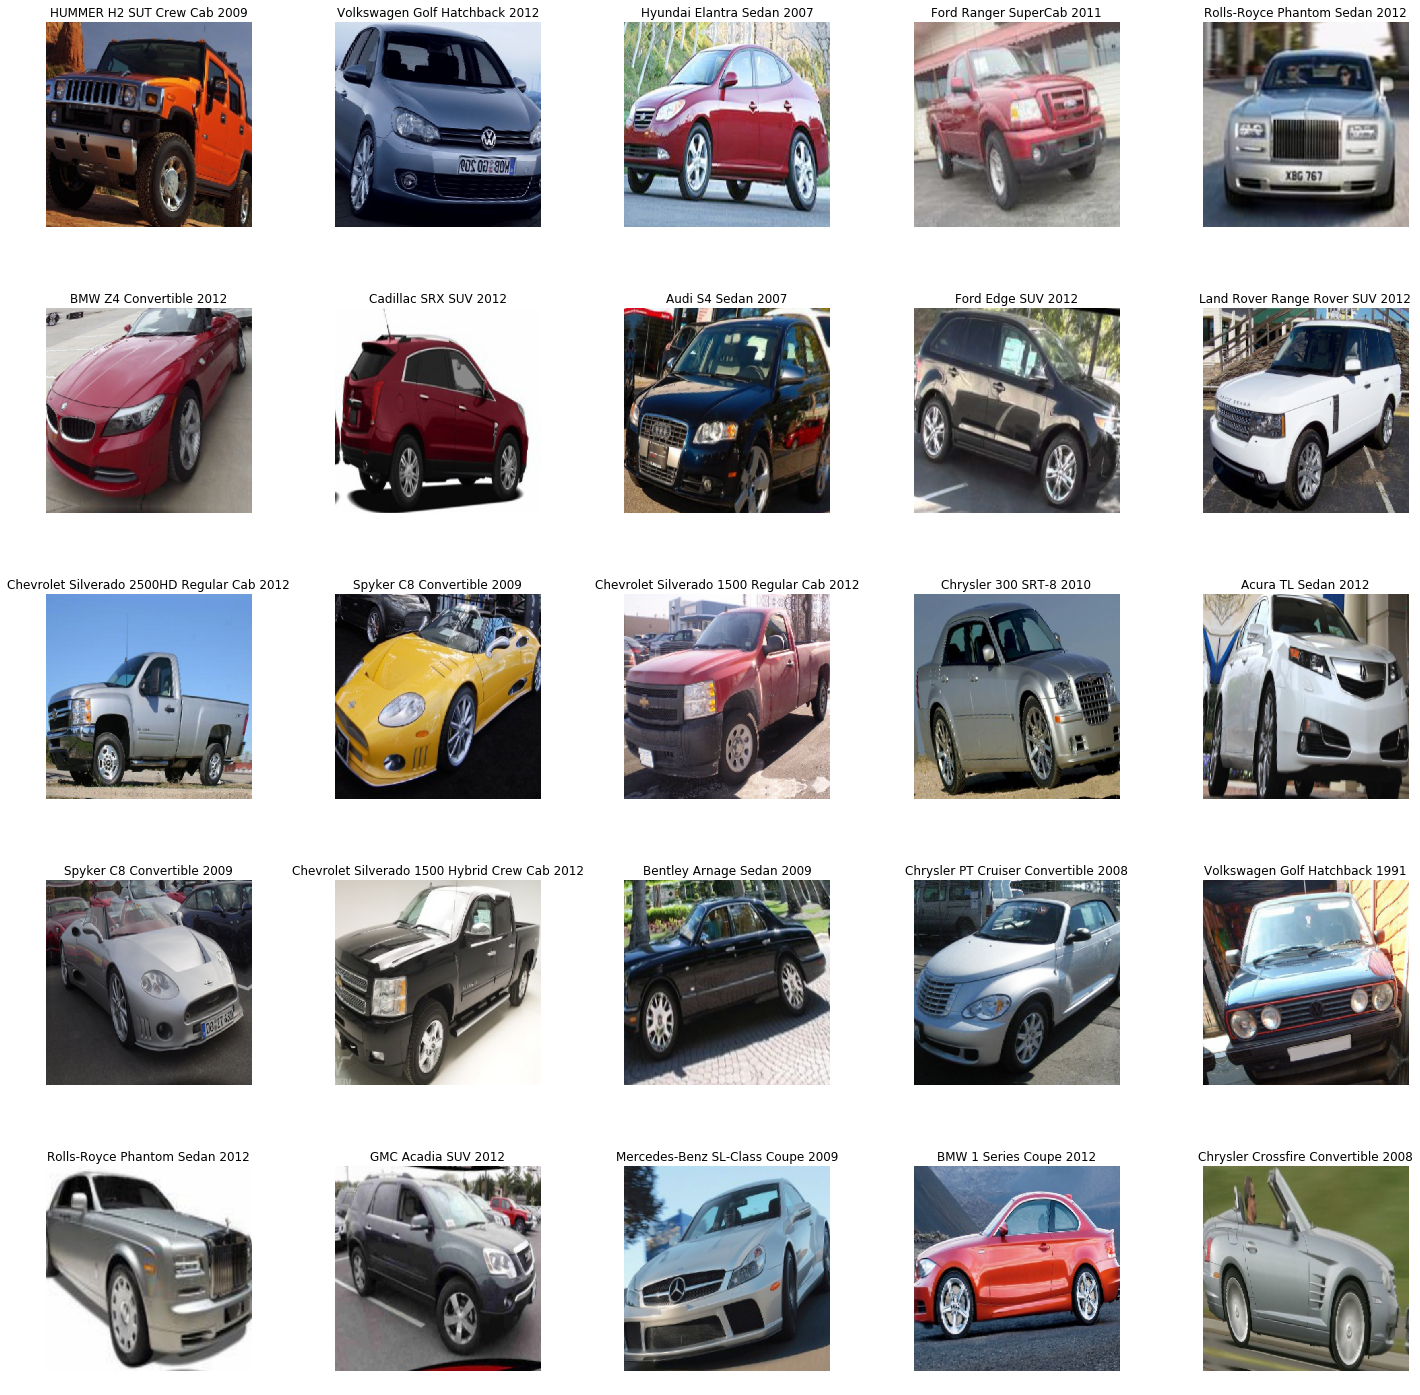

In [63]:
data_notfms.show_batch()

In [64]:
len(data_notfms.classes)

196

In [65]:
learn1 = create_cnn(data_notfms, models.resnet34, pretrained=True, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


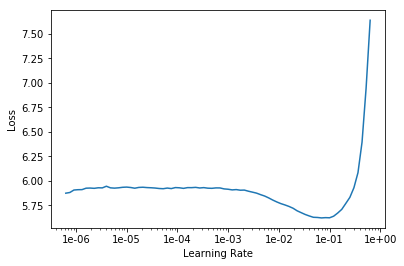

In [66]:
learn1.lr_find()
learn1.recorder.plot()

In [67]:
learn1.fit_one_cycle(10, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.880353,3.790269,0.191529,0.808471,00:51
2,3.125976,3.216400,0.289748,0.710252,00:50
3,2.534672,2.183772,0.467772,0.532228,00:51
4,1.952862,1.973542,0.510129,0.489871,00:51
5,1.550468,1.880594,0.534684,0.465316,00:52
6,1.197501,1.193806,0.680172,0.319828,00:52
7,0.879247,0.914511,0.757520,0.242480,00:52
8,0.602857,0.638590,0.823204,0.176796,00:53
9,0.439531,0.571621,0.842234,0.157766,00:52
10,0.341213,0.555517,0.842848,0.157152,00:52


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


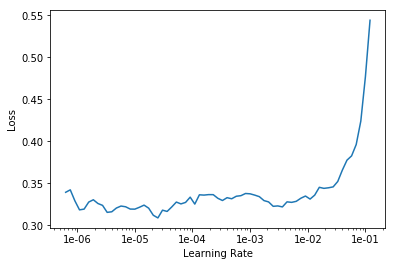

In [69]:
learn1.lr_find()
learn1.recorder.plot()

In [70]:
learn1.unfreeze()
learn1.fit_one_cycle(9, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.337373,0.547512,0.844076,0.155924,01:10
2,0.323396,0.552695,0.845304,0.154696,01:12
3,0.314765,0.537567,0.846532,0.153468,01:12
4,0.281424,0.490782,0.866789,0.133211,01:12
5,0.235417,0.466450,0.868017,0.131983,01:12
6,0.216058,0.435850,0.879067,0.120933,01:12
7,0.199711,0.442097,0.877839,0.122161,01:12
8,0.179405,0.438376,0.875998,0.124002,01:12
9,0.166418,0.436505,0.875384,0.124616,01:12


## Test Time Augmentation

After training each model I performed a test time augmentation to attempt to increase accuracy.

In [71]:
log_preds, y = learn1.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8711)

In [72]:
learn1.save('no_tfms_2')

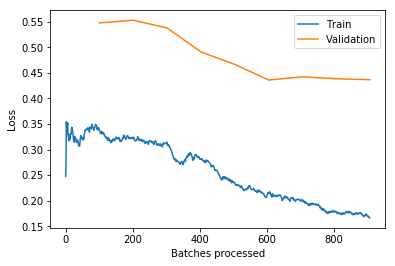

In [73]:
learn1.recorder.plot_losses()

# Second Model: Resnet-34 With Custom Augmentations

For this model I again used resnet 34 but I added my own augmentations in an attempt to achieve increased accuracy.  I started training from the results of model 1.  I achieved an accuracy of ~84%

In [74]:
xtra_tfms = [jitter(magnitude=0.01,p=0.5), squish(scale = 0.66)]
tfms = get_transforms(flip_vert=False,
                      do_flip=True,
                      max_rotate=30.0,
                      max_zoom=1.5,
                      max_lighting=0.4,
                      max_warp=0.4,
                      xtra_tfms=xtra_tfms)

data_tfms = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=tfms,size=512).normalize(imagenet_stats)
learn2 = create_cnn(data_tfms, models.resnet34, metrics=[accuracy, error_rate]).load('no_tfms_2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


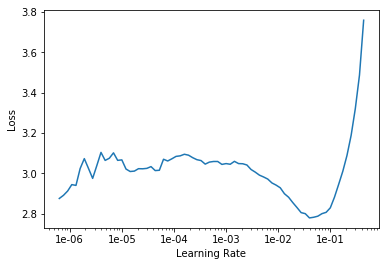

In [75]:
learn2.lr_find()
learn2.recorder.plot()

In [76]:
learn2.fit_one_cycle(10, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,2.130389,0.668121,0.811541,0.188459,00:51
2,1.928817,1.093159,0.684469,0.315531,00:52
3,2.202518,1.624812,0.573972,0.426028,00:52
4,2.202628,1.566531,0.580724,0.419276,00:53
5,2.091188,1.522148,0.598527,0.401473,00:53
6,1.821225,1.037393,0.702885,0.297115,00:53
7,1.513399,0.918573,0.748926,0.251074,00:53
8,1.272756,0.783755,0.777164,0.222836,00:52
9,1.107507,0.714779,0.794352,0.205648,00:53
10,1.006040,0.705723,0.796808,0.203192,00:52


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


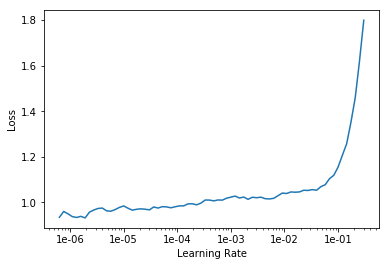

In [77]:
learn2.lr_find()
learn2.recorder.plot()

In [78]:
learn2.unfreeze()
learn2.fit_one_cycle(9, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.983044,0.691579,0.798649,0.201351,01:09
2,0.966817,0.671903,0.803560,0.196440,01:11
3,0.960946,0.675551,0.802947,0.197053,01:13
4,0.904483,0.630996,0.812155,0.187845,01:13
5,0.844192,0.630383,0.818293,0.181707,01:13
6,0.812069,0.592801,0.829957,0.170043,01:12
7,0.767823,0.567921,0.836710,0.163290,01:12
8,0.756219,0.566639,0.838551,0.161449,01:12
9,0.725157,0.562360,0.838551,0.161449,01:13


In [79]:
log_preds, y = learn2.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8625)

In [80]:
learn2.save('tfms_1')

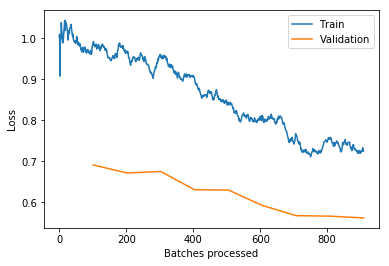

In [81]:
learn2.recorder.plot_losses()

Data augmentations Don't seem to improve the accuracy, therefore I won't test it on the following models

# Third Model: Resnet-50

For this model, I used the resnet50 architecture, default fast ai data augmentations and a pretrained model.  This model achieved an accuracy after TTA of around 88%

In [84]:
data_notfms_2 = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=get_transforms(), size=400).normalize(imagenet_stats)
learn3 = create_cnn(data_notfms_2, models.resnet50, pretrained=True, metrics=[accuracy, error_rate])

In [85]:
learn3.fit_one_cycle(10, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.253230,3.061732,0.298956,0.701044,01:12
2,2.703871,4.323582,0.186618,0.813382,01:07
3,2.332625,2.814861,0.368938,0.631062,01:08
4,1.717602,2.217596,0.475138,0.524862,01:08
5,1.371689,1.726375,0.564764,0.435236,01:08
6,1.022032,1.001513,0.723143,0.276857,01:07
7,0.717805,0.719248,0.801719,0.198281,01:07
8,0.424331,0.537486,0.843462,0.156538,01:08
9,0.277580,0.434388,0.874156,0.125844,01:07
10,0.200574,0.421445,0.870473,0.129527,01:07


In [86]:
learn3.save('50-notfms-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


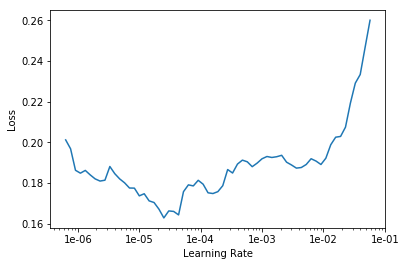

In [87]:
learn3.lr_find()
learn3.recorder.plot()

In [88]:
learn3.unfreeze()
learn3.fit_one_cycle(9, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.184326,0.418297,0.875384,0.124616,01:26
2,0.180836,0.413997,0.880295,0.119705,01:25
3,0.181563,0.415602,0.879681,0.120319,01:26
4,0.170562,0.401080,0.882750,0.117250,01:27
5,0.156088,0.395327,0.885819,0.114180,01:27
6,0.139380,0.393482,0.883364,0.116636,01:27
7,0.136521,0.389318,0.882750,0.117250,01:27
8,0.130582,0.390073,0.885206,0.114794,01:26
9,0.130601,0.389451,0.884592,0.115408,01:27


In [90]:
log_preds, y = learn3.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8846)

In [91]:
learn3.save('50-notfms-2')

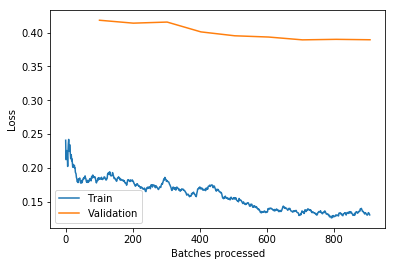

In [92]:
learn3.recorder.plot_losses()

# Top Losses

Here I plot the top losses to see what combinations of classes were most often confused with one another

In [94]:
interp = ClassificationInterpretation.from_learner(learn3)

losses,idxs = interp.top_losses()

len(data_notfms_2.valid_ds)==len(losses)==len(idxs)

True

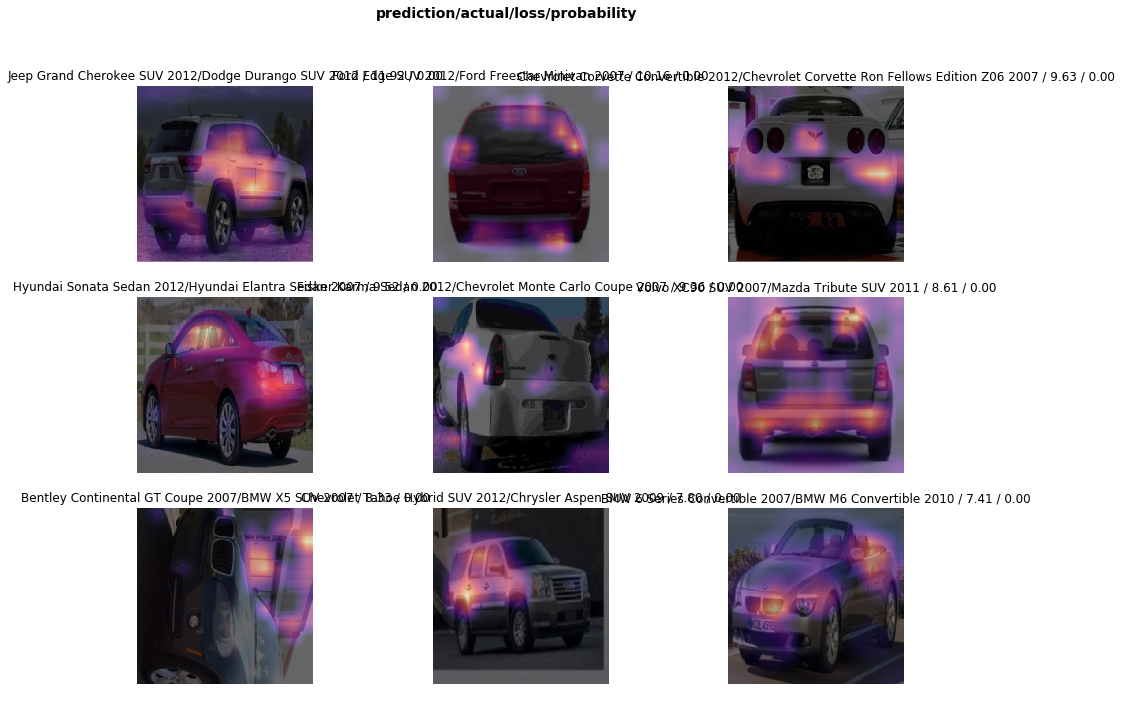

In [95]:
interp.plot_top_losses(9, figsize=(15,11))

In [99]:
interp.most_confused(min_val=2)

[('Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 4),
 ('BMW M6 Convertible 2010', 'BMW 6 Series Convertible 2007', 4),
 ('Audi S5 Coupe 2012', 'Audi A5 Coupe 2012', 3),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 3),
 ('BMW Z4 Convertible 2012', 'Ferrari California Convertible 2012', 3),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 3),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 2500HD Regular Cab 2012',
  3),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  3),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3),
 ('Ferrari 458 Italia Coupe 2012', 'Ferrari 458 Italia Convertible 2012', 3),
 ('Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Sedan 2012', 3),
 ('Rolls-Royce Phantom Sedan 2012', 'Rolls-Royce Ghost Sedan 2012', 3),
 ('Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin Virage Convertible 2012',
  2),
 ('Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin V8 Va

The most confused classes appear to be cars that even humans would have trouble differentiating.  The most common example is cars of the same make but different models and different years.

# Fourth Model: Resnet-152

For this model I used the resnet 152 architecture and default augmentations.  This model achieved an accuracy after TTA of around 90.5%

In [103]:
data_notfms_3 = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=get_transforms(), size=276).normalize(imagenet_stats)
learn4 = create_cnn(data_notfms_3, models.resnet152, pretrained=True, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


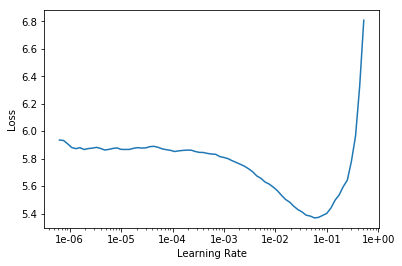

In [101]:
learn4.lr_find()
learn4.recorder.plot()

In [104]:
learn4.fit_one_cycle(10, 1.58e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,3.930803,3.090939,0.265193,0.734807,01:14
2,2.717567,4.671022,0.165746,0.834254,01:16
3,2.405021,3.755752,0.262738,0.737262,01:16
4,1.778088,2.822123,0.365869,0.634131,01:17
5,1.491448,1.914856,0.532842,0.467158,01:16
6,1.117299,1.044850,0.710252,0.289748,01:16
7,0.751374,0.714712,0.800491,0.199509,01:16
8,0.502654,0.513582,0.849601,0.150399,01:16
9,0.303876,0.418708,0.883364,0.116636,01:16
10,0.223174,0.410881,0.884592,0.115408,01:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


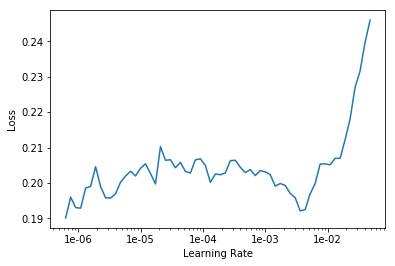

In [107]:
learn4.lr_find()
learn4.recorder.plot()

In [108]:
learn4.unfreeze()
learn4.fit_one_cycle(9, max_lr=slice(1e-4,4.5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.558301,1.700246,0.591160,0.408840,01:39
2,1.154608,3.174698,0.374463,0.625537,01:42
3,1.088639,1.441542,0.616329,0.383671,01:43
4,0.838413,1.509955,0.618171,0.381829,01:43
5,0.633174,0.728962,0.794352,0.205648,01:42
6,0.450550,0.537482,0.845304,0.154696,01:42
7,0.307264,0.431293,0.881522,0.118478,01:43
8,0.188210,0.364158,0.896869,0.103131,01:42
9,0.140688,0.356862,0.898711,0.101289,01:41


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


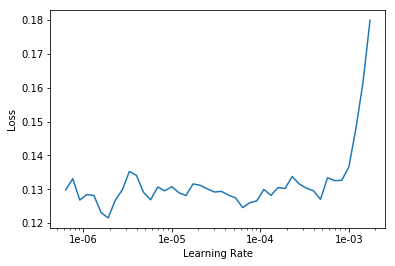

In [109]:
learn4.lr_find()
learn4.recorder.plot()

In [110]:
learn4.unfreeze()
learn4.fit_one_cycle(9, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.135821,0.354164,0.900553,0.099448,01:43
2,0.134533,0.354501,0.899325,0.100675,01:43
3,0.119521,0.348172,0.899939,0.100061,01:43
4,0.119957,0.346801,0.903008,0.096992,01:42
5,0.115354,0.346017,0.904236,0.095764,01:42
6,0.115549,0.344859,0.904850,0.095150,01:42
7,0.112192,0.342417,0.903008,0.096992,01:43
8,0.120413,0.343436,0.904236,0.095764,01:42
9,0.123335,0.342387,0.905463,0.094537,01:42


In [112]:
log_preds, y = learn4.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.9018)

In [116]:
learn4.save("152-notfms")

In [118]:
interp = ClassificationInterpretation.from_learner(learn4)

losses,idxs = interp.top_losses()

len(data_notfms_2.valid_ds)==len(losses)==len(idxs)

interp.most_confused(min_val=2)

[('Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 5),
 ('Audi TT RS Coupe 2012', 'Audi TT Hatchback 2011', 4),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 4),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 4),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Sedan 2012', 3),
 ('Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin Virage Convertible 2012',
  2),
 ('Aston Martin Virage Convertible 2012',
  'Aston Martin V8 Vantage Convertible 2012',
  2),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 2),
 ('BMW M6 Convertible 2010', 'BMW 6 Series Convertible 2007', 2),
 ('Bentley Continental GT Coupe 2007', 'Bentley Continental GT Coupe 2012', 2),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 2500HD Regular Cab 2012',
  2),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  2),
 ('Chevrolet Silverado 1500 Regular Cab 2012',


# Fifth Model: Densenet 161

This model uses densenet161 architecture and default augmentations.  It achieved an accuracy of around 90.8% after TTA

In [128]:
data_notfms_4 = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train','valid',ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn5 = create_cnn(data_notfms_4, models.densenet161, pretrained=True, metrics=[accuracy, error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


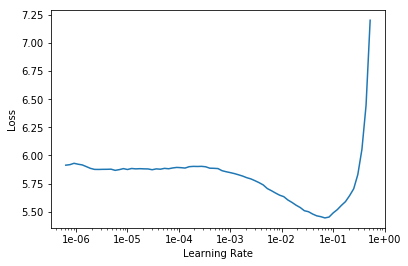

In [129]:
learn5.lr_find()
learn5.recorder.plot()

In [130]:
learn5.fit_one_cycle(10, 1.3e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.191775,2.995825,0.317373,0.682627,00:54
2,2.529486,5.291567,0.188459,0.811541,00:53
3,2.345044,3.155466,0.295273,0.704727,00:53
4,1.699830,1.748261,0.549417,0.450583,00:53
5,1.327872,1.568035,0.603438,0.396562,00:54
6,0.995019,0.999455,0.712093,0.287907,00:54
7,0.665185,0.713739,0.793125,0.206875,00:54
8,0.438744,0.565743,0.836096,0.163904,00:54
9,0.279711,0.506270,0.856354,0.143646,00:53
10,0.210966,0.486393,0.861878,0.138122,00:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


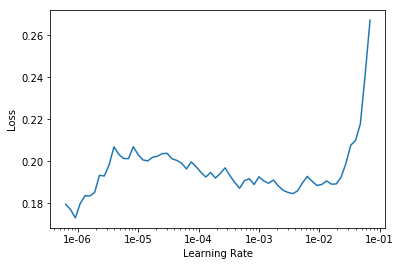

In [131]:
learn5.lr_find()
learn5.recorder.plot()

In [132]:
learn5.unfreeze()
learn5.fit_one_cycle(9,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.188820,0.470503,0.866789,0.133211,01:09
2,0.211318,0.514361,0.847145,0.152855,01:09
3,0.239859,0.518987,0.856354,0.143646,01:10
4,0.219671,0.521195,0.850829,0.149171,01:10
5,0.179474,0.467902,0.872928,0.127072,01:10
6,0.139194,0.426288,0.875998,0.124002,01:10
7,0.105553,0.401110,0.888275,0.111725,01:10
8,0.084587,0.387621,0.891958,0.108042,01:09
9,0.069290,0.386205,0.893800,0.106200,01:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


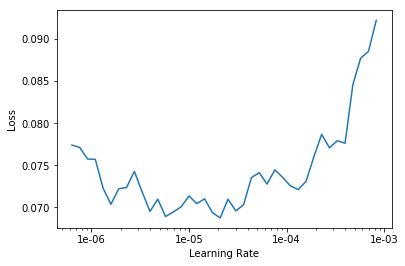

In [133]:
learn5.lr_find()
learn5.recorder.plot()

In [134]:
learn5.unfreeze()
learn5.fit_one_cycle(9,max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.068671,0.388460,0.891958,0.108042,01:09
2,0.073179,0.385433,0.893800,0.106200,01:10
3,0.070702,0.379320,0.894414,0.105586,01:10
4,0.062691,0.377874,0.895642,0.104359,01:10
5,0.068128,0.378214,0.894414,0.105586,01:10
6,0.069149,0.375639,0.895028,0.104972,01:10
7,0.065741,0.375156,0.898711,0.101289,01:09
8,0.068272,0.377879,0.894414,0.105586,01:09
9,0.068967,0.374915,0.896869,0.103131,01:09


In [136]:
log_preds, y = learn5.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.9085)

# Conclusion

Out of all the models the two with resnet-152 and Desnenet-161 architecture Had the best performance of around 90%.  Now Ill reprocess the data to sort it by class ID so I can use it to predict the test set.  I'll use the resnet-152 model

In [139]:
def make_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def save_train_data_id(fnames, labels, bboxes):
    src_folder ='/home/amccarthy13/Documents/cars_dataset/cars_train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/train_id/'
        else:
            dst_folder = '/home/amccarthy13/Documents/cars_dataset/valid_id/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = '/home/amccarthy13/Documents/cars_dataset/cars_test/'
    dst_folder = '/home/amccarthy13/Documents/cars_dataset/test/'
    num_samples = len(fnames)

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data_id():
    cars_annos = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    save_train_data_id(fnames, labels, bboxes)


def process_test_data():
    cars_annos = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

cars_meta = scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/devkit/cars_meta')
class_names = cars_meta['class_names']  
class_names = np.transpose(class_names)

make_folder('/home/amccarthy13/Documents/cars_dataset/train_id')
make_folder('/home/amccarthy13/Documents/cars_dataset/valid_id')
make_folder('/home/amccarthy13/Documents/cars_dataset/test')

#process_train_data_id()
process_test_data()

In [160]:
data_final = ImageDataBunch.from_folder('/home/amccarthy13/Documents/cars_dataset/','train_id','valid_id',ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn_final = create_cnn(data_final, models.resnet152, pretrained=True, metrics=[accuracy, error_rate])
print(data_final.classes)

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


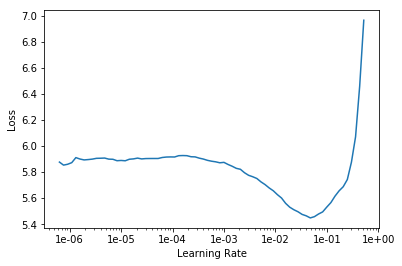

In [161]:
learn_final.lr_find()
learn_final.recorder.plot() 

In [162]:
learn_final.fit_one_cycle(10, 1.58e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,4.069500,2.877247,0.305095,0.694905,00:49
2,2.880209,4.200913,0.196440,0.803560,00:49
3,2.541089,3.529629,0.246163,0.753837,00:49
4,1.961666,3.065786,0.317986,0.682014,00:50
5,1.563475,2.121686,0.492940,0.507060,00:50
6,1.220587,1.293692,0.658686,0.341314,00:50
7,0.876167,0.761179,0.775936,0.224064,00:50
8,0.570789,0.574499,0.841621,0.158379,00:50
9,0.388772,0.516275,0.862492,0.137508,00:50
10,0.280620,0.501928,0.866176,0.133824,00:50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


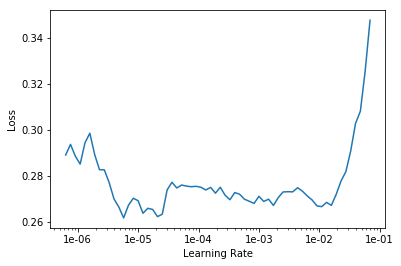

In [163]:
learn_final.lr_find()
learn_final.recorder.plot()

In [164]:
learn_final.unfreeze()
learn_final.fit_one_cycle(9, max_lr=slice(1e-4,4.5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.654094,2.142936,0.522406,0.477594,01:05
2,1.243993,2.336167,0.467158,0.532842,01:07
3,1.140146,1.213791,0.672805,0.327195,01:07
4,0.913425,1.108968,0.697360,0.302640,01:08
5,0.717512,0.997491,0.750767,0.249233,01:08
6,0.507648,0.589409,0.843462,0.156538,01:07
7,0.344218,0.469753,0.866789,0.133211,01:07
8,0.231643,0.404691,0.886433,0.113567,01:06
9,0.166518,0.396750,0.886433,0.113567,01:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


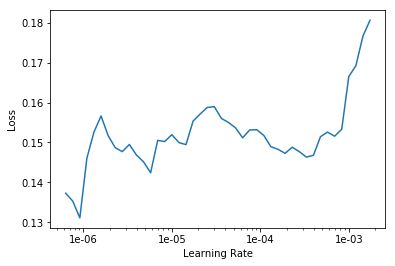

In [165]:
learn_final.lr_find()
learn_final.recorder.plot()

In [166]:
learn_final.unfreeze()
learn_final.fit_one_cycle(9, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.143900,0.395156,0.886433,0.113567,01:06
2,0.151882,0.393741,0.889503,0.110497,01:08
3,0.155084,0.391893,0.886433,0.113567,01:08
4,0.144781,0.389163,0.890117,0.109883,01:08
5,0.146633,0.389770,0.890731,0.109269,01:08
6,0.144860,0.392366,0.889503,0.110497,01:07
7,0.144556,0.389072,0.889503,0.110497,01:08
8,0.136957,0.388960,0.888889,0.111111,01:05
9,0.132189,0.389460,0.888275,0.111725,01:06


In [167]:
log_preds, y = learn_final.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8877)

In [168]:
learn_final.save('dense-final')

In [169]:
labels=scipy.io.loadmat('/home/amccarthy13/Documents/cars_dataset/cars_test_annos_withlabels.mat')

In [170]:
x=[]
for i in range(8041):
    x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])

In [171]:
df = pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),
                 index=x)

In [172]:
df.to_csv('/home/amccarthy13/Documents/cars_dataset/test_labels.csv')

In [173]:
learn_final.export('/home/amccarthy13/Documents/cars_dataset/export.pkl')
learn_test = load_learner('/home/amccarthy13/Documents/cars_dataset/', test=ImageList.from_csv('/home/amccarthy13/Documents/cars_dataset/','test_labels.csv',folder='/test'))
preds,y = learn_test.TTA(ds_type=DatasetType.Test)

In [174]:
a=preds;a.shape

torch.Size([8041, 196])

In [175]:
b=np.array(labels['annotations']['class'], dtype=np.int)-1;b.shape
b= torch.from_numpy(b)

In [176]:
acc=accuracy(a,b);acc

tensor(0.8891)